# Spatial Data Mining with Canadia Tweets

*Due Wednesday December 10th, 2018 at 11:59 pm*
*Notebook Author: Koki Sasagawa*

Spatial data mining on Canadian tweets to detect regional variation in word usage. 

## Data
1. Words aggregated into Canadian Census regions 
2. Spatial distance matrix that describes which counties are next to eachother 
3. Demo code is provided 

In [2]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import numpy as np
import pysal
import matplotlib.pyplot as plt
import time 
from sklearn.decomposition import PCA

# Demo
## Load in the color values your analysis produced

In [3]:
color_df = pd.read_csv('random-subdivision-values.tsv', sep='\t', dtype={'CSDUID': object})
print('Number of rows: {}'.format(color_df.shape[0]))
color_df.head()

Number of rows: 4224


,CSDUID,color_value
0,5915022,-0.237788
1,5919008,0.291066
2,3520005,-0.845814
3,4611040,0.152208
4,3539036,-0.585537


## Read the shapefile as a GeoDataFrame

In [4]:
canada_df = gpd.GeoDataFrame.from_file("gcsd000b11a_e.shp")
print(canada_df.shape)
canada_df.head(2)

(5253, 19)


,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CMAUID,CMANAME,CMATYPE,CMAPUID,SACTYPE,SACCODE,ERUID,ERNAME,CCSUID,CCSNAME,geometry
0,5943816,Quatsino Subdivision 18,IRI,59,British Columbia / Colombie-Britannique,5943,Mount Waddington,RD,None,None,None,None,7,999,5910,Vancouver Island and Coast / Île de Vancouver ...,5943031,Mount Waddington C,POLYGON ((-127.5741642679999 50.61221324100006...
1,5915062,Bowen Island,IM,59,British Columbia / Colombie-Britannique,5915,Greater Vancouver,RD,933,Vancouver,B,59933,1,933,5920,Lower Mainland--Southwest / Lower Mainland--Su...,5915020,Greater Vancouver A,(POLYGON ((-123.3803824129999 49.4117749990000...


## Merge in the color specifications for each point

In [5]:
# Create copy of original dataframe
demo_plot = canada_df.copy()
demo_plot = demo_plot.merge(color_df, on='CSDUID')
demo_plot.shape

(4224, 20)

## Plot everything
Geopandas makes this pretty easy
Check out http://geopandas.org/gallery/plotting_with_geoplot.html for more documentation.  You might try different map projections, different color schemes, or different plots altogether! 

In [6]:
# Set coordinate reference system
demo_plot.crs = {'init' : 'epsg:4326'}

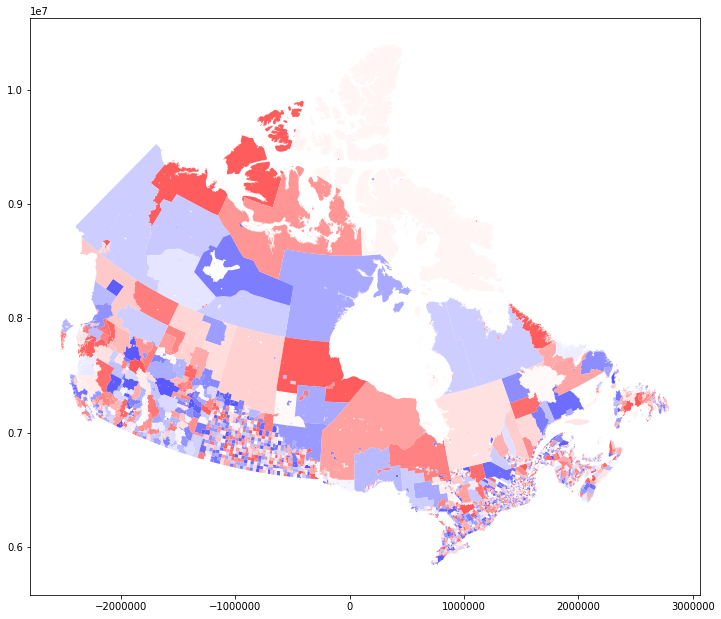

In [7]:
#plot the shapefile/GeoDataFrame
g = demo_plot.to_crs("+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs").plot(column='color_value', vmin=-3, vmax=3, cmap='seismic', figsize=(12, 12))

# Getis-Ord Statistics for spatial association 

## 1. Load data

In [8]:
word_counts = pd.read_csv('subdivision_to_word_counts.tsv', sep='\t', header=None, names=['CSDUID', 'WORDCOUNT'])
print(word_counts.shape)
word_counts.head()

(4224, 2)


,CSDUID,WORDCOUNT
0,5915022,by 10610 david 212 featuring 786 is 18567 in 2...
1,5919008,pst 2105 wind 2604 mph 2604 barometer 2604 in ...
2,3520005,nba 319 made 3500 a 97237 big 3546 mistake 253...
3,4611040,i 24551 mean 411 doing 529 that 7714 against 1...
4,3539036,min 27 phone 171 call 191 with 2517 pizza 97 t...


In [9]:
word_counts.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4224 entries, 0 to 4223
Data columns (total 2 columns):
CSDUID       4224 non-null int64
WORDCOUNT    4224 non-null object
dtypes: int64(1), object(1)
memory usage: 31.6 MB


In [10]:
region_neighbors = pd.read_csv('subdivision-to-neighbors.tsv', sep='\t', header=None, names=['CSDUID', 'NEIGHBORS'])
print(region_neighbors.shape)
region_neighbors.head()

(4240, 2)


,CSDUID,NEIGHBORS
0,2402047,2403015 2402047 2426015 2426010 1215011 241090...
1,5933019,5933019 5933015 5909027 5921034 5921032 595180...
2,2426015,2402047 2448045 2471065 2426015 2426010 247300...
3,2426010,2402047 2448045 2471065 2426015 2426010 247300...
4,1215011,2403015 2402047 1215011 1306020 1101009 110100...


In [11]:
region_neighbors.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 2 columns):
CSDUID       4240 non-null int64
NEIGHBORS    4240 non-null object
dtypes: int64(1), object(1)
memory usage: 23.7 MB


## 2. Format Data

In [12]:
# Convert CSDUID to list
regions = region_neighbors.CSDUID.astype('str').tolist()

# List of tuples of CSDUID and neighbors 
n_list = list(zip(region_neighbors.CSDUID.astype('str').tolist(), [x.split() for x in region_neighbors.NEIGHBORS]))

print(regions[:5])
print('Type of CSDUID: {}'.format(type(n_list[0][0])))
print('Type of NEIGHBORS: {}'.format(type(n_list[0][1][0])))
print('Number of neighbors in first row: {}'.format(len(n_list[:1][0][1])))

['2402047', '5933019', '2426015', '2426010', '1215011']
Type of CSDUID: <class 'str'>
Type of NEIGHBORS: <class 'str'>
Number of neighbors in first row: 748


In [13]:
# Nested dict of CSDUID and all neighbors initialized with value 1
neighbors = {}

for t in n_list:
    k = t[0]
    values = t[1]
    neighbors[k]={}
    for v in values:
        neighbors[k][v]=1

In [14]:
# List of regions with words
w_regions = word_counts.CSDUID.astype(str).tolist()
print(w_regions[:5])
print(len(w_regions))

['5915022', '5919008', '3520005', '4611040', '3539036']
4224


In [15]:
%%time 

words_by_region = []

for i in word_counts.itertuples():
    # CSDUID
    region_id = i[1]
    
    # Word counts e.g, ['apple', '23', ...]
    word_list = i[2].split()
    
    # Iterate every 2 to get word and number
    uniq_word_counts = {}    
    it = iter(word_list)
    for x in it:
        if x not in uniq_word_counts:
            uniq_word_counts[x] = next(it)
    
    words_by_region.append(pd.Series(uniq_word_counts).to_frame(name=region_id))

CPU times: user 3.85 s, sys: 87 ms, total: 3.93 s
Wall time: 3.95 s


In [16]:
print(words_by_region[0].info(memory_usage='deep'))
words_by_region[0].head()

<class 'pandas.core.frame.DataFrame'>
Index: 9713 entries, by to fifty
Data columns (total 1 columns):
5915022    9713 non-null object
dtypes: object(1)
memory usage: 1.2 MB
None


,5915022
by,10610
david,212
featuring,786
is,18567
in,24940


In [17]:
# Combine all dataframes into one. Transpose so row and column switch
region_word_matrix = pd.concat(words_by_region, axis=1, sort=False, join='outer').transpose()
region_word_matrix.fillna(0,inplace=True)

In [18]:
print(region_word_matrix.info(memory_usage='deep'))
region_word_matrix.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4224 entries, 5915022 to 5931814
Columns: 10000 entries, by to gmt+0000
dtypes: object(10000)
memory usage: 1.3 GB
None


,by,david,featuring,is,in,vera,on,the,drive,vancouver,...,sainte-catherine,saint-marc,mont-tremblant,hausse,pointe-claire,pierre-elliott-trudeau,lente,dp-,n/gust,gmt+0000
5915022,10610,212,786,18567,24940,6909,17058,44997,7200,19253,...,0,0,0,0,0,0,0,0,0,0
5919008,34,2,0,151,5402,0,94,407,4,9,...,0,0,0,0,0,0,0,0,0,0
3520005,10414,632,183,57654,67355,9,61868,152713,720,173,...,0,0,0,0,0,0,0,0,0,0
4611040,2051,95,10,10790,11881,1,7437,26666,222,41,...,0,0,0,0,0,0,0,0,0,0
3539036,663,21,6,4560,4975,1,4424,11055,85,4,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Region neighbors dataframe had more rows than word count
# Some regions did not have any words
empty_regions = [i for i in regions if i not in w_regions]
empty_regions

['2442100',
 '2435035',
 '2494255',
 '2484035',
 '4716014',
 '4623058',
 '4711094',
 '4711041',
 '2450057',
 '2406005',
 '2431035',
 '4813013',
 '6103097',
 '2488010',
 '5931844',
 '2433040']

In [20]:
# Add missing CSDUID with 0 
for _id in empty_regions:
    region_word_matrix.loc[int(_id)] = 0

In [21]:
region_word_matrix.shape

(4240, 10000)

In [22]:
# Save the word matrix for easy access earlier
region_word_matrix.to_csv('./region_word_matrix.csv')

## 3. Get weights

In [23]:
# Get weights
weights = pysal.weights.weights.W(neighbors, id_order=region_word_matrix.index.astype('str'))
weights.n

4240

In [24]:
# Save weights 
gal = pysal.open('./weights.gal','w')
gal.write(weights)
gal.close()

In [25]:
def local_getisord_by_word(word, w=weights, perm=99):
    '''Calculate the local getisord of word over regions
    
    :param word: word count across regions
    :type word: DataFrame
    :param int perm: number of permutations 
    :returns score: z_sim scores
    :rtype: list of int 
    '''
    
    y = np.array(word).astype('int')
    g = pysal.esda.getisord.G_Local(y, weights, star=True, permutations=perm)
    score = g.z_sim
    
    return score

## 4. Try local getisord on the word 'vancourver' 

In [26]:
# All counts of the word vancouver 
test_1 = region_word_matrix[['vancouver']].astype(int)
test_1.head()

,vancouver
5915022,19253
5919008,9
3520005,173
4611040,41
3539036,4


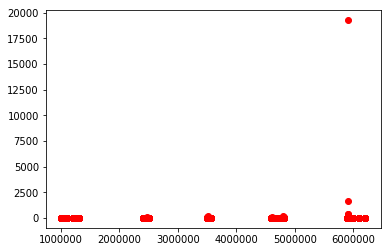

In [27]:
plt.plot(test_1.index, test_1['vancouver'], 'ro')

In [28]:
%%time 
test_1 = test_1.apply(local_getisord_by_word)

CPU times: user 6.36 s, sys: 320 ms, total: 6.68 s
Wall time: 6.77 s


In [33]:
test_1_plot = canada_df.copy()
test_1_plot.head(3)

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CMAUID,CMANAME,CMATYPE,CMAPUID,SACTYPE,SACCODE,ERUID,ERNAME,CCSUID,CCSNAME,geometry
0,5943816,Quatsino Subdivision 18,IRI,59,British Columbia / Colombie-Britannique,5943,Mount Waddington,RD,None,None,None,None,7,999,5910,Vancouver Island and Coast / Île de Vancouver ...,5943031,Mount Waddington C,POLYGON ((-127.5741642679999 50.61221324100006...
1,5915062,Bowen Island,IM,59,British Columbia / Colombie-Britannique,5915,Greater Vancouver,RD,933,Vancouver,B,59933,1,933,5920,Lower Mainland--Southwest / Lower Mainland--Su...,5915020,Greater Vancouver A,(POLYGON ((-123.3803824129999 49.4117749990000...
2,5943027,Mount Waddington B,RDA,59,British Columbia / Colombie-Britannique,5943,Mount Waddington,RD,None,None,None,None,7,999,5910,Vancouver Island and Coast / Île de Vancouver ...,5943027,Mount Waddington B,(POLYGON ((-127.8539747939999 50.1760356960000...


In [34]:
# Convert CSDUID to int type
test_1_plot['CSDUID'] = test_1_plot['CSDUID'].astype('int')

In [35]:
# Convert to 'object' type to merge 
test_1['CSDUID'] = test_1.index
print(test_1.info(memory_usage='deep'))
test_1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4240 entries, 5915022 to 2433040
Data columns (total 2 columns):
vancouver    4240 non-null float64
CSDUID       4240 non-null int64
dtypes: float64(1), int64(1)
memory usage: 99.4 KB
None


,vancouver,CSDUID
5915022,6.168560,5915022
5919008,3.382507,5919008
3520005,-0.304315,3520005
4611040,-0.350224,4611040
3539036,-0.296583,3539036


In [36]:
test_1_plot = test_1_plot.merge(test_1, on='CSDUID')
test_1_plot.shape

(4240, 20)

In [37]:
# Set coordinate reference system
test_1_plot.crs = {'init' : 'epsg:4326'}

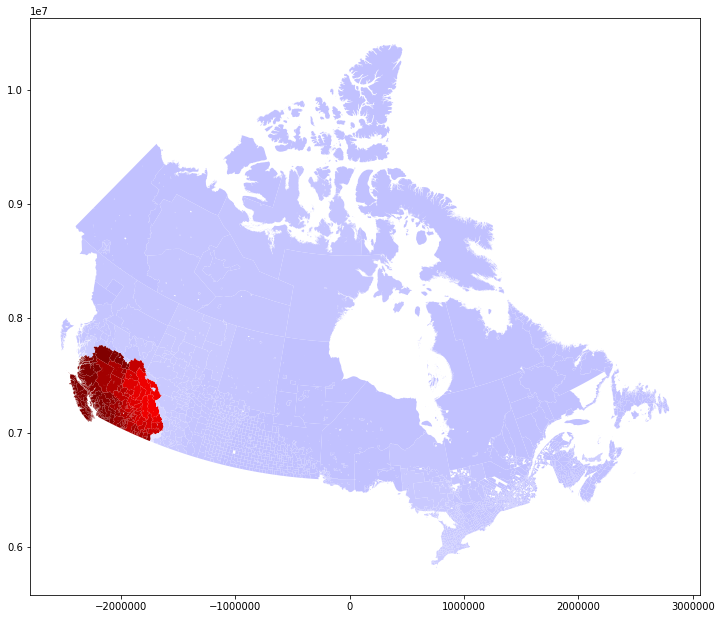

In [38]:
#plot the shapefile/GeoDataFrame
g = test_1_plot.to_crs("+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs").plot(column='vancouver', vmin=-3, vmax=3, cmap='seismic', figsize=(12, 12))
plt.savefig('./vancouver.png')

We see that the word vancouver clusters very highly towards the west coast side of Canada around vancouver area.
It is insignificant elsewhere in the rest of Canada. 

## 5. Plot the z score of the local getisord for target words

In [155]:
# Test to see if a word exists 
word = 'cold'

if word in region_word_matrix.columns.tolist():
    print(True)

True


In [168]:
# All counts of the word vancouver 
candidate_words = region_word_matrix[['hot', 'cold', 'french', 'lgbt', 'moose', 'goose', 'hockey']].astype('int')
candidate_words.head()

,hot,cold,french,lgbt,moose,goose,hockey
5915022,530,261,130,9,29,16,229
5919008,4,6,0,0,0,0,6
3520005,2143,1702,503,19,88,128,945
4611040,413,343,86,5,21,18,296
3539036,179,129,29,1,4,12,99


In [169]:
%%time
# local getisord on words of interest
results = candidate_words.apply(local_getisord_by_word)

CPU times: user 23.7 s, sys: 1.16 s, total: 24.9 s
Wall time: 25 s


In [171]:
results.head()

,hot,cold,french,lgbt,moose,goose,hockey
5915022,1.140990,0.374298,0.521426,4.290556,0.586294,0.610023,0.730278
5919008,0.627917,0.059173,0.063221,4.036614,0.095762,0.297771,0.299477
3520005,4.924707,4.927767,5.093938,1.168997,2.568234,4.295958,5.132834
4611040,-0.499961,-0.361997,-0.706782,-0.296785,-0.681182,-0.325761,-0.193314
3539036,6.773795,6.534167,5.324920,1.350697,3.634286,5.473890,7.125632


In [172]:
results['CSDUID'] = results.index

In [173]:
plot_data = canada_df.copy()
plot_data['CSDUID'] = plot_data['CSDUID'].astype('int')
plot_data = plot_data.merge(results, on='CSDUID')
plot_data.shape

In [175]:
plot_data.crs = {'init' : 'epsg:4326'}

In [176]:
def word_mapper(data, word):
    '''Plot the local getisord score for word
    
    :param data: plot geopandas DataFrame
    :param str word: word of interest
    '''
    
    g = data.to_crs("+proj=lcc +lat_1=49 +lat_2=77 +lon_0=-91.52 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs").plot(column=word, vmin=-3, vmax=3, cmap='seismic', figsize=(12, 12))
    plt.savefig('./images/{}.png'.format(word))

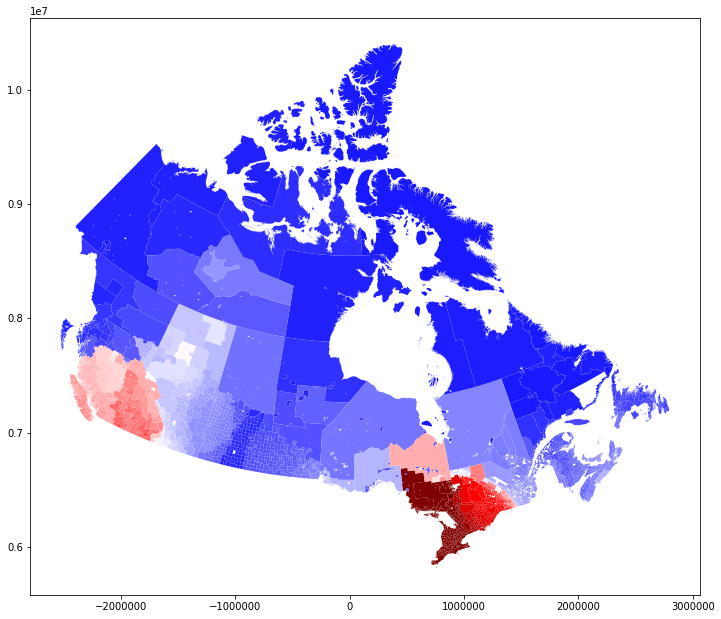

In [177]:
word_mapper(plot_data, 'hot')

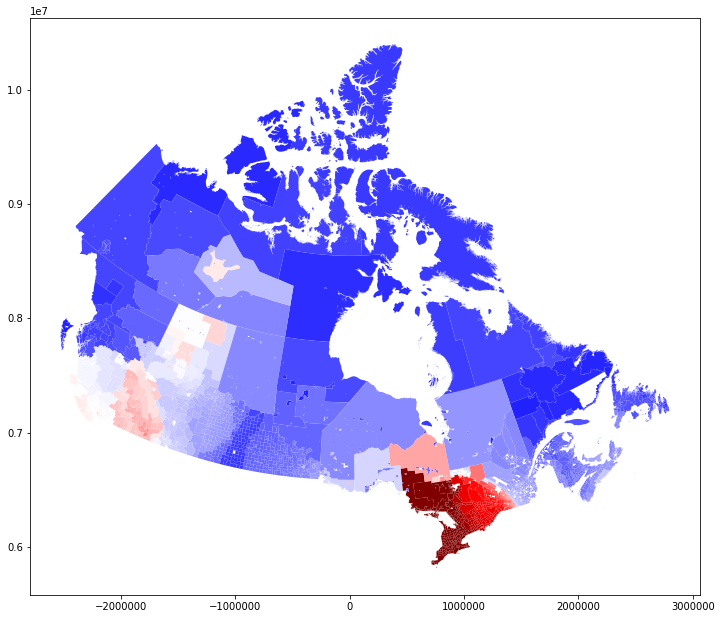

In [178]:
word_mapper(plot_data, 'cold')

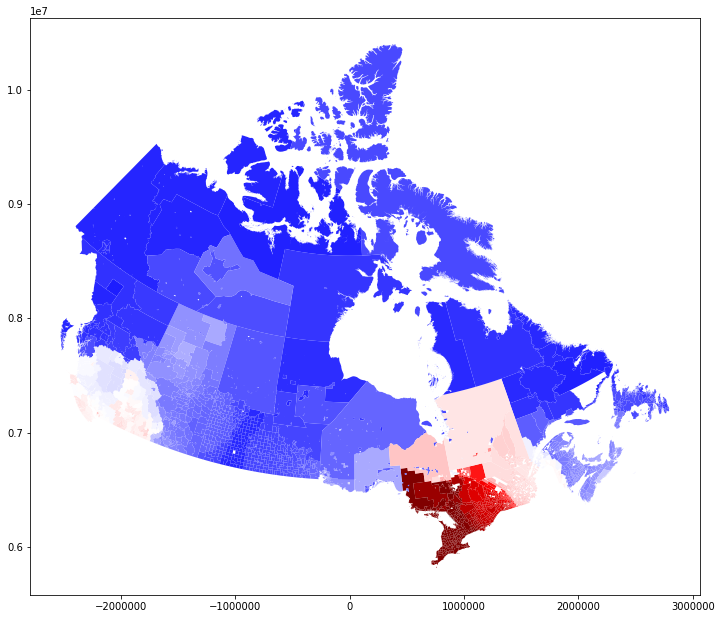

In [99]:
word_mapper(plot_data, 'french')

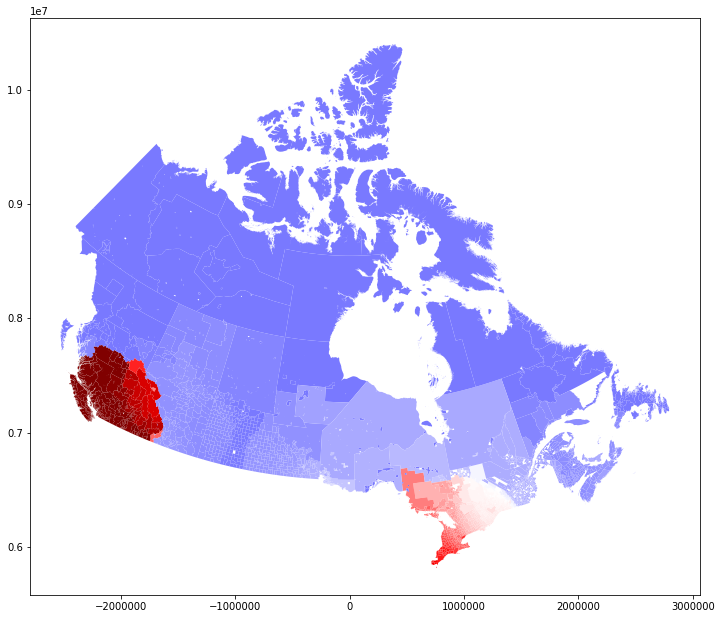

In [164]:
word_mapper(plot_data, 'lgbt')

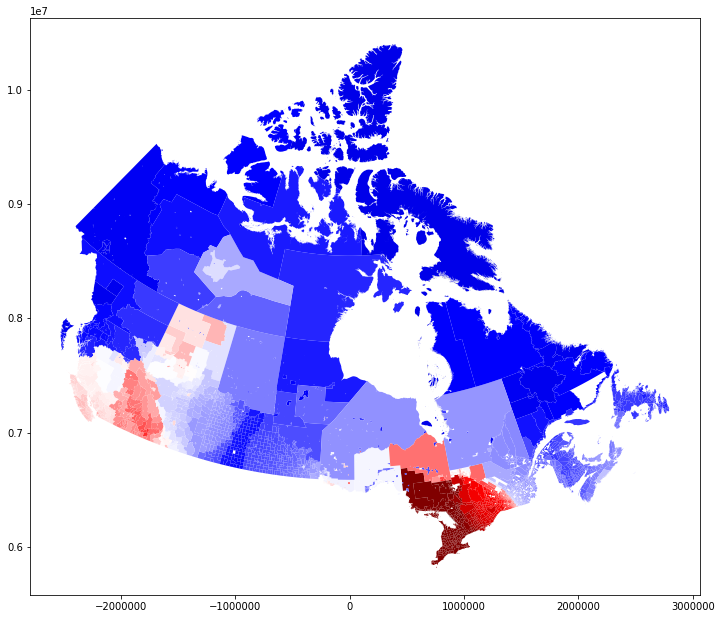

In [102]:
word_mapper(plot_data, 'hockey')

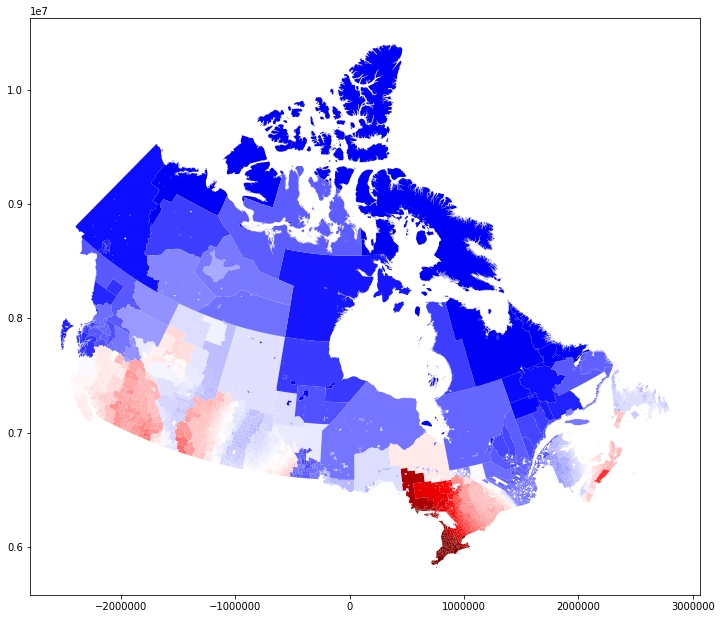

In [112]:
word_mapper(plot_data, 'moose')

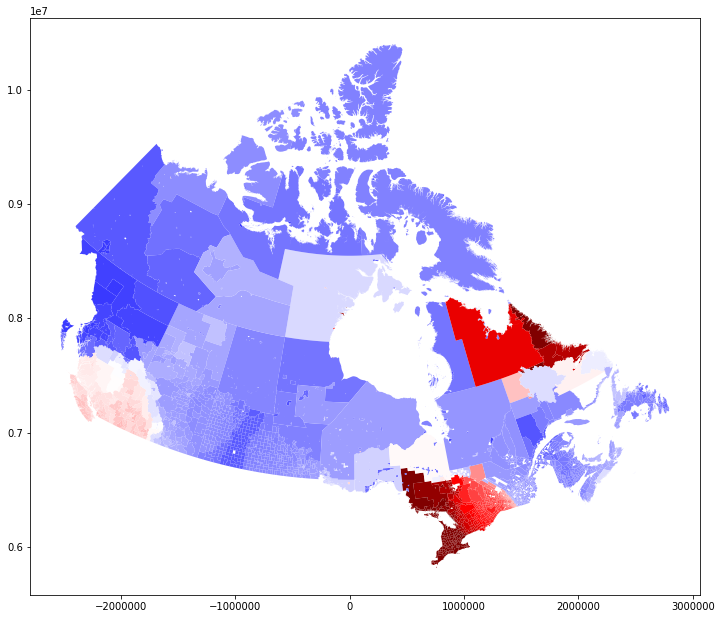

In [165]:
word_mapper(plot_data, 'goose')

## 6. Run getisord on entire dataset and compute PCA

In [38]:
# Load region word matrix
word_matrix = pd.read_csv('./region_word_matrix.csv', index_col=0)

In [40]:
print(word_matrix.shape)
word_matrix.head()

(4240, 10000)


,by,david,featuring,is,in,vera,on,the,drive,vancouver,...,sainte-catherine,saint-marc,mont-tremblant,hausse,pointe-claire,pierre-elliott-trudeau,lente,dp-,n/gust,gmt+0000
5915022,10610,212,786,18567,24940,6909,17058,44997,7200,19253,...,0,0,0,0,0,0,0,0,0,0
5919008,34,2,0,151,5402,0,94,407,4,9,...,0,0,0,0,0,0,0,0,0,0
3520005,10414,632,183,57654,67355,9,61868,152713,720,173,...,0,0,0,0,0,0,0,0,0,0
4611040,2051,95,10,10790,11881,1,7437,26666,222,41,...,0,0,0,0,0,0,0,0,0,0
3539036,663,21,6,4560,4975,1,4424,11055,85,4,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Split the dataframe into smaller subsets
splits = np.array_split(word_matrix.columns.tolist(), 10)

In [65]:
# Save as separate files to run getisord calculations on multiple systems
for i in range(0,len(splits)):
    split = word_matrix[splits[i].tolist()]
    split.to_csv('{}k_words.csv'.format(i+1))

In [67]:
# List all files 
files = os.listdir('./split_words')
files

['5k_words.csv',
 '8k_words.csv',
 '2k_words.csv',
 '7k_words.csv',
 '4k_words.csv',
 '9k_words.csv',
 '1k_words.csv',
 '6k_words.csv',
 '3k_words.csv',
 '10k_words.csv']

In [69]:
# Run the first 3 files on this machine 
file_1 = pd.read_csv('./split_words/1k_words.csv', index_col=0)
file_2 = pd.read_csv('./split_words/2k_words.csv', index_col=0)
file_3 = pd.read_csv('./split_words/3k_words.csv', index_col=0)

In [70]:
print("All files should have 1000 columns and 4240 rows")
print(file_1.shape)
print(file_2.shape)
print(file_3.shape)

# Preview of table
file_1.head()

All files should have 1000 columns and 4240 rows
(4240, 1000)
(4240, 1000)
(4240, 1000)


,by,david,featuring,is,in,vera,on,the,drive,vancouver,...,scratch,impressive,trend,gents,pt,sap,intern,associate,product,wants
5915022,10610,212,786,18567,24940,6909,17058,44997,7200,19253,...,20,36,29,10,21,41,32,75,70,203
5919008,34,2,0,151,5402,0,94,407,4,9,...,0,0,1,0,1,0,1,1,0,1
3520005,10414,632,183,57654,67355,9,61868,152713,720,173,...,112,119,121,34,101,37,53,243,302,1174
4611040,2051,95,10,10790,11881,1,7437,26666,222,41,...,29,16,22,3,16,2,3,40,29,318
3539036,663,21,6,4560,4975,1,4424,11055,85,4,...,15,2,12,5,9,3,3,14,13,86


In [75]:
start = time.time()
# local getisord on words of interest
results_1 = file_1.apply(local_getisord_by_word)
results_2 = file_2.apply(local_getisord_by_word)
results_3 = file_3.apply(local_getisord_by_word)
end = time.time()

print('Local Getisord on 3 files completed in: {}'.format(end-start))

print('Saving files...')
results_1.to_csv('./results/results_1.csv')
results_2.to_csv('./results/results_2.csv')
results_3.to_csv('./results/results_3.csv')
print('*****DONE*****')

Local Getisord on 3 files completed in: 9086.650696992874
Saving files...


In [78]:
print("All files should have 1000 columns and 4240 rows")
print(results_1.shape)
print(results_2.shape)
print(results_3.shape)

# Preview of table
results_1.head()

All files should have 1000 columns and 4240 rows
(4240, 1000)
(4240, 1000)
(4240, 1000)


,by,david,featuring,is,in,vera,on,the,drive,vancouver,...,scratch,impressive,trend,gents,pt,sap,intern,associate,product,wants
5915022,3.895743,1.554072,6.113742,1.153155,1.768336,5.295847,1.007839,1.290010,5.431506,5.987270,...,0.472083,1.255484,-0.221163,0.865356,0.439054,1.454664,2.221958,0.901292,1.150964,0.436373
5919008,2.057213,0.719831,3.065629,0.545909,1.168776,2.627360,0.395465,0.644342,2.694857,3.282706,...,0.094283,0.597633,-0.264184,0.266703,0.259916,0.400796,1.007258,0.329840,0.575603,0.073816
3520005,3.413936,4.183764,0.813768,4.401122,4.650043,-0.263264,4.573236,4.800522,0.538721,-0.296280,...,4.619132,4.258775,0.156406,5.182326,3.525890,2.807579,3.397958,3.950665,4.471664,5.738647
4611040,-0.449742,-0.330857,-0.459265,-0.446914,-0.586937,-0.272895,-0.544487,-0.488149,-0.357945,-0.340846,...,-0.078789,-0.547444,-0.328444,-0.937549,-0.508691,-0.796521,-0.592936,-0.600157,-0.547399,-0.195153
3539036,4.375675,4.722548,0.941332,5.913809,6.051882,-0.260698,6.001839,6.325822,0.994839,-0.288774,...,6.249213,5.191837,0.285540,7.034036,5.638655,2.316460,3.590311,4.931842,5.408525,8.001889


In [89]:
# Combine all results 
print('Loading all results...')
results_1 = pd.read_csv('./results/results_1.csv', index_col=0)
results_2 = pd.read_csv('./results/results_2.csv', index_col=0)
results_3 = pd.read_csv('./results/results_3.csv', index_col=0)
results_4 = pd.read_csv('./results/results_4.csv', index_col=0)
results_5 = pd.read_csv('./results/results_5.csv', index_col=0)
results_6 = pd.read_csv('./results/results_6.csv', index_col=0)
results_7 = pd.read_csv('./results/results_7.csv', index_col=0)
results_8 = pd.read_csv('./results/results_8.csv', index_col=0)
results_9 = pd.read_csv('./results/results_9.csv', index_col=0)
results_10 = pd.read_csv('./results/results_10.csv', index_col=0)
print('*****DONE*****')

Loading all results...
*****DONE*****


In [90]:
# Check all files 
print("All files should have 1000 columns and 4240 rows")
print(results_1.shape)
print(results_2.shape)
print(results_3.shape)
print(results_4.shape)
print(results_5.shape)
print(results_6.shape)
print(results_7.shape)
print(results_8.shape)
print(results_9.shape)
print(results_10.shape)

All files should have 1000 columns and 4240 rows
(4240, 1000)
(4240, 1000)
(4240, 1000)
(4240, 1000)
(4240, 1000)
(4240, 1000)
(4240, 1000)
(4240, 1000)
(4240, 1000)
(4240, 1000)


In [95]:
# Preview of table
results_2.head()

,action,well,hello,agree,tough,worse,isn't,done,slip,moose,...,traded,jb,fruits,recommend,shower,sauna,mata,chelsea,outta,planes
5915022,1.527721,0.804486,1.792071,0.942361,1.436413,0.644036,0.724400,0.653365,0.790826,0.612307,...,0.729751,0.118622,2.313473,1.762548,0.544348,1.630363,-0.234902,0.054320,-0.177323,1.660326
5919008,0.850110,0.381262,1.096839,0.520742,0.839705,0.255181,0.321796,0.262345,0.407073,0.099829,...,0.388715,-0.106886,1.182850,1.026263,0.106795,1.434076,-0.317465,-0.153041,-0.362494,1.062273
3520005,4.010787,5.070844,4.535885,4.457093,4.601102,5.134021,5.326553,5.173201,4.862030,2.682921,...,4.880671,6.114867,4.166665,4.120871,5.661359,5.263944,4.127752,5.043857,5.825960,4.541379
4611040,-0.450395,-0.433472,-0.627713,-0.535949,-0.461178,-0.522411,-0.413322,-0.559074,-0.835381,-0.711876,...,-0.203371,-0.855568,-0.615908,-0.801106,-0.564362,-0.827611,-0.055580,-0.535735,-0.056096,-0.583084
3539036,4.911931,7.070888,5.753497,5.977202,6.293353,7.399865,7.561474,7.124976,6.681244,3.796669,...,6.767452,8.112305,4.412747,5.262440,7.781389,7.425362,4.693877,6.746111,8.216553,5.949041


In [96]:
# Combine all dataframes together
full_results = pd.concat([results_1, results_2, results_3, results_4, results_5, results_6, results_7, results_8, results_9, results_10], axis=1)

In [97]:
# should be 10000 columns and 4240 rows
full_results.shape

(4240, 10000)

In [98]:
# Save output 
full_results.to_csv('./results/full_results.csv')

## 7. Get the top 3 Principle Components

In [101]:
pca = PCA(n_components=3)

In [103]:
%%time
principalComponents = pca.fit_transform(full_results)

CPU times: user 5.46 s, sys: 661 ms, total: 6.12 s
Wall time: 2.33 s


In [105]:
pca_data = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2', 'pc3'])

In [106]:
pca_data.head()

,pc1,pc2,pc3
0,96.651481,99.256246,2.913660
1,51.111416,73.827625,-0.228917
2,447.509678,-14.257330,2.031535
3,-36.079143,-7.418042,-1.113544
4,595.960360,-20.103161,2.954482


In [107]:
pca_data['CSDUID'] = full_results.index

In [108]:
print(pca_data.shape)
pca_data.head()

(4240, 4)


,pc1,pc2,pc3,CSDUID
0,96.651481,99.256246,2.913660,5915022
1,51.111416,73.827625,-0.228917,5919008
2,447.509678,-14.257330,2.031535,3520005
3,-36.079143,-7.418042,-1.113544,4611040
4,595.960360,-20.103161,2.954482,3539036


In [109]:
# Plot the PC
plot_pca = canada_df.copy()
plot_pca['CSDUID'] = plot_pca['CSDUID'].astype('int')
plot_pca = plot_pca.merge(pca_data, on='CSDUID')
plot_pca.crs = {'init' : 'epsg:4326'}

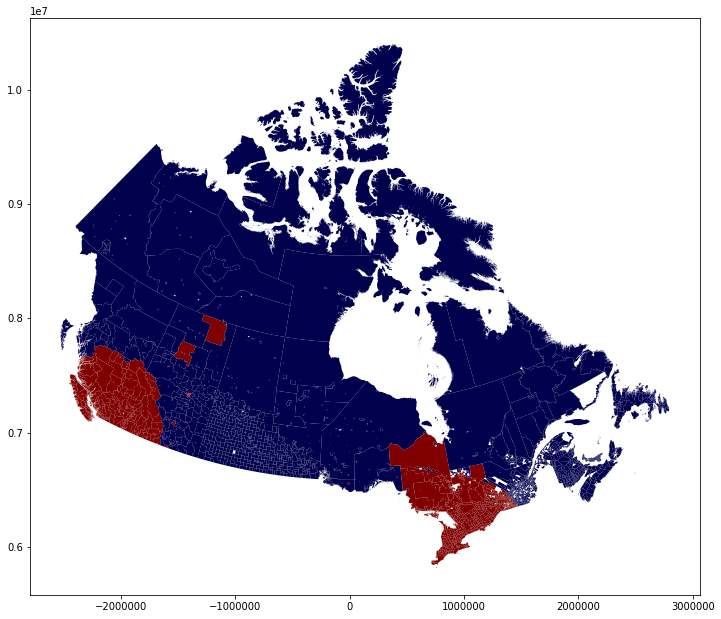

In [114]:
word_mapper(plot_pca, 'pc1')

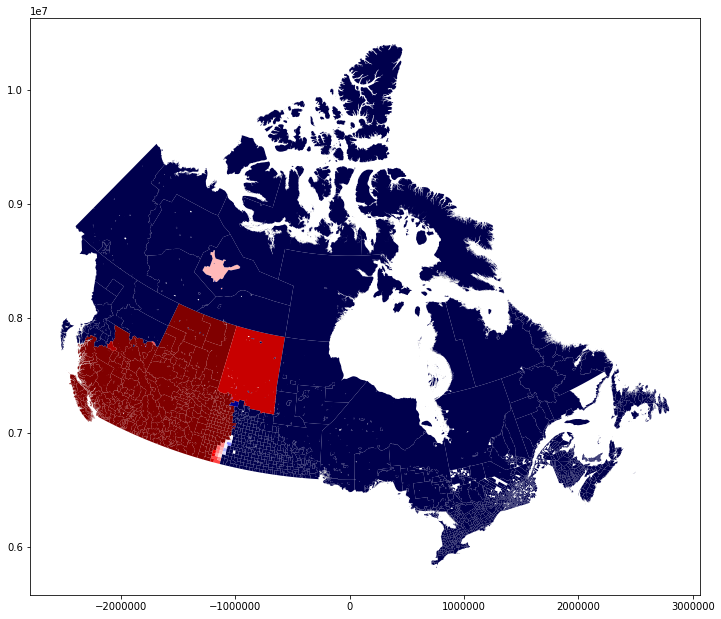

In [115]:
word_mapper(plot_pca, 'pc2')

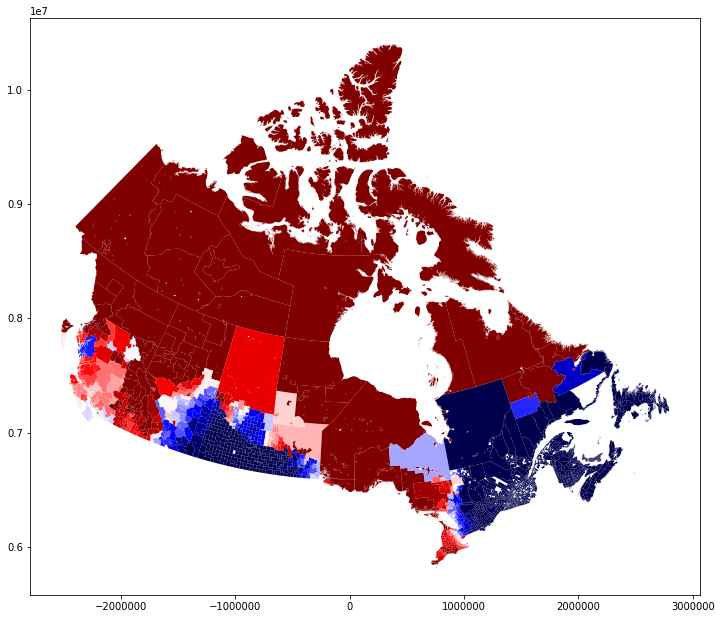

In [116]:
word_mapper(plot_pca, 'pc3')

## 8. Recovering feature names in PC

In [179]:
# Use pca.components_ which outputs an array of n_components and n_features.
# Each coefficient represents the correlation between a particular pair of component and feature 
feature_names = pd.DataFrame(pca.components_, columns=full_results.columns, index = ['pc1','pc2', 'pc3']).transpose()

In [187]:
print(feature_names.shape)
feature_names

(10000, 3)


,pc1,pc2,pc3
by,0.008241,0.018959,1.711965e-03
david,0.008375,0.002207,1.042241e-02
featuring,0.002955,0.030946,1.753390e-04
is,0.010060,0.000711,-4.626112e-04
in,0.010625,0.007426,1.511620e-03
vera,0.000724,0.027620,4.289178e-04
on,0.010085,-0.001707,5.825356e-04
the,0.010781,0.001807,1.151772e-03
drive,0.002766,0.027556,2.704993e-05
vancouver,0.000966,0.034611,6.443786e-04


In [188]:
feature_names['pc1'].sort_values(ascending=False)[:50]

cottage         0.023813
g2              0.021838
conservation    0.020796
von             0.020258
chirp           0.019668
g1              0.018333
chirping        0.018214
aloud           0.018123
friggen         0.018087
defiantly       0.018050
gunna           0.017696
highschool      0.017509
tn              0.017407
boyfriends      0.017216
timmies         0.017215
camping         0.017045
golf            0.017024
sluts           0.016991
text            0.016979
hangout         0.016976
fishing         0.016969
barn            0.016847
farm            0.016797
dock            0.016619
probs           0.016611
faggot          0.016588
pita            0.016543
sesh            0.016406
awh             0.016395
tractor         0.016317
dads            0.016304
burnt           0.016246
golfing         0.016125
yaaa            0.016094
hunny           0.016089
prom            0.015953
bud             0.015947
puke            0.015878
slut            0.015792
worker          0.015778


In [190]:
feature_names['pc2'].sort_values(ascending=False)[:50]

british…      0.091254
hiking        0.085051
resort        0.082891
kesler        0.082787
okanagan      0.076479
hike          0.076139
campground    0.073275
british       0.073131
mountains     0.073003
columbia      0.070585
bc            0.069529
fraser        0.067888
mountain      0.067229
tug           0.065841
b.c.          0.064328
luongo        0.063341
elk           0.061438
canucks       0.061039
ferry         0.059811
ca-bc         0.054721
rockies       0.054585
peaks         0.054082
racer         0.053770
skiing        0.052535
grizzly       0.052479
ipa           0.052371
skytrain      0.052005
sfu           0.051997
coast         0.051791
seattle       0.051374
glacier       0.051305
alpine        0.048762
scenery       0.048294
oregon        0.047716
ski           0.047257
lagoon        0.047081
springs       0.046980
denny         0.046318
summit        0.045797
mortgage      0.045386
canyon        0.044599
ubc           0.044564
regional      0.044375
seymour    

In [191]:
feature_names['pc3'].sort_values(ascending=False)[:50]

composite    0.207221
modis        0.203441
tile         0.199721
gmt+0000     0.198480
processed    0.197124
utc          0.194357
server       0.172240
jaina        0.161515
droid        0.152993
cst          0.147506
flood        0.145724
han          0.144482
published    0.144057
cdt          0.141887
jedi         0.141211
leia         0.140625
appears      0.139863
anakin       0.139003
verified     0.138915
originals    0.130725
rts          0.129493
enlawded     0.129171
users        0.128112
trends       0.126712
jun          0.126504
trend        0.120194
mention      0.120003
sep          0.116304
map          0.114828
adidas       0.110304
apr          0.104856
topic        0.102915
tl           0.101512
alert        0.099722
trending     0.097635
impact       0.095570
jul          0.092875
client       0.091951
helped       0.091491
accounts     0.091455
became       0.085359
tweets       0.079918
web          0.077339
alaska       0.069931
tue          0.069854
toward    